In [1]:
%load_ext autoreload

In [2]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.datasets import MNIST, CIFAR10

from networks import *
from utils import *
from losses import *

import matplotlib.pyplot as plt

In [12]:
# Set seed, clear cache
set_seed(42)
torch.cuda.empty_cache()

train_transform = Compose([
    Resize(28),
    ToTensor(),
])

# Set training static parameters and hyperparameters
parameters = dict(
    nepochs=200,
    dims_latent = 10,                              
    learning_rate=1e-3,
    batch_size=1,                                        
    transform=train_transform,
    device=set_device("cuda"),
    )

# Model saving settings
save_model = False
save_frequency = 5

# access all HPs through wandb.config, so logging matches execution!
config = setup_config_offline(parameters)


Cuda installed! Running on GPU GeForce RTX 2080 Ti!


torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])


Training started ...
{'epoch': 0, 'mse_loss': 0.23184512555599213, 'awi2d_loss': 31.980632781982422, 'awi1d_loss': 0}
1D argidx T, v:  0 0
2D argidx T, v:  377 471


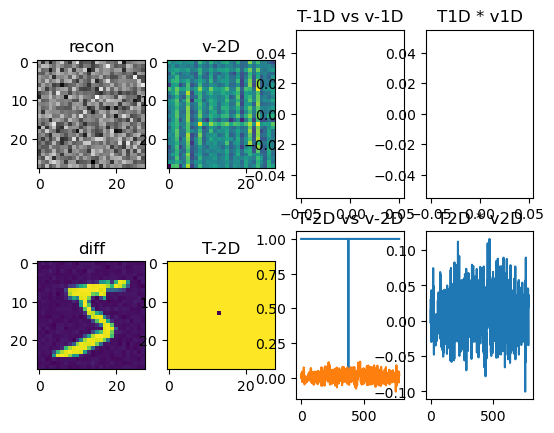

{'epoch': 50, 'mse_loss': 0.08978329598903656, 'awi2d_loss': 30.395769119262695, 'awi1d_loss': 0}
1D argidx T, v:  0 0
2D argidx T, v:  377 377


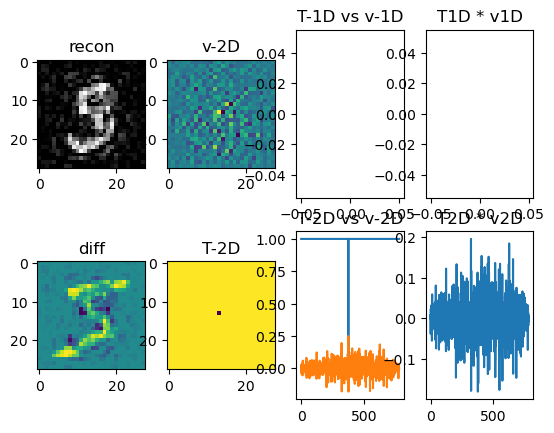

{'epoch': 100, 'mse_loss': 0.08674812316894531, 'awi2d_loss': 28.96204948425293, 'awi1d_loss': 0}
1D argidx T, v:  0 0
2D argidx T, v:  377 377


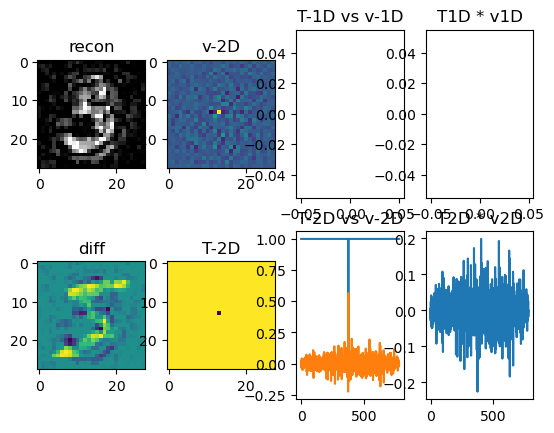

{'epoch': 150, 'mse_loss': 0.08676454424858093, 'awi2d_loss': 27.90190315246582, 'awi1d_loss': 0}
1D argidx T, v:  0 0
2D argidx T, v:  377 377


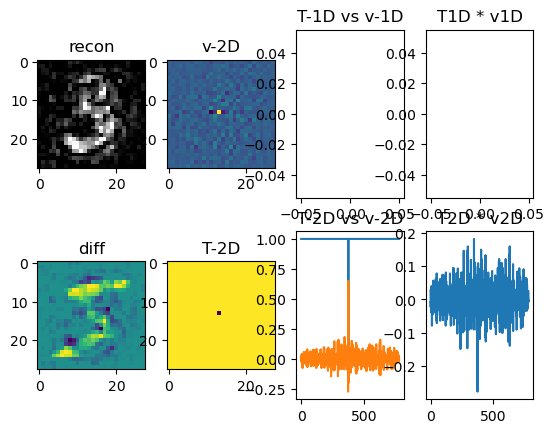

{'epoch': 199, 'mse_loss': 0.08823481947183609, 'awi2d_loss': 27.015419006347656, 'awi1d_loss': 0}
1D argidx T, v:  0 0
2D argidx T, v:  377 377


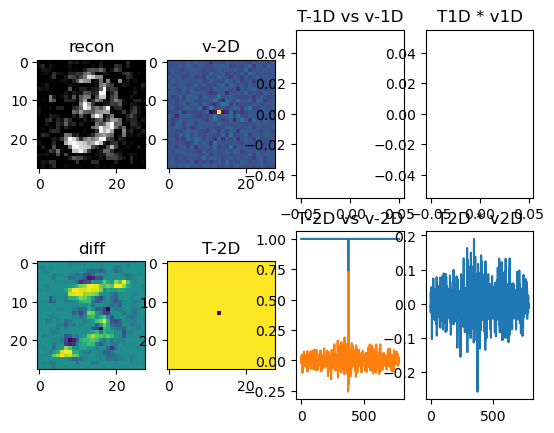

In [15]:
%autoreload 2
from losses import *
from networks import *
torch.autograd.set_detect_anomaly(True)

# Data
trainds = MNIST("./", download=False, train=True, transform=parameters["transform"])
X = torch.zeros(64, 1, 28, 28)
for i in range(X.size(0)):
    X[i] = trainds[i][0]


# Model and optim
model = Autoencoder(dims_latent=config.dims_latent, nc=X.size(1))
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)


# Input / Output test
print(X.shape, model(X).shape)

# Losses: total_loss = a*awi + w*mse +  c*total_variation
w, mse =     0.0, torch.nn.MSELoss()
a1d, awi1D = 0.0,  AWILoss1D()
a2d, awi2D = 1.0,  AWILoss2D()
c, tv =      0.0,  TV()
switch_at_epoch = 10 # swtich from pure mse to total loss, set to 0 to disable    

# Send to devices
X = X.to(config.device)
model = model.to(config.device)

#Other params
idx = 0 # idx of batch to inspect
std = 1e-4

# Training loop
print("\n\nTraining started ...")    
for epoch in range(config.nepochs):
    model.train()
    optimizer.zero_grad()
    recon = model(X)

    # MSE and TV losses
    mse_loss = mse(recon, X)
    tv_loss =  tv(recon)

    # AWI 1D Loss
    # awi1d_loss, v1D, T1D =  awi1D(recon, X, std=std, alpha=0. , epsilon=0.)
    awi1d_loss, v1D, T1D = torch.tensor([0], device=config.device), torch.tensor([0], device=config.device), torch.tensor([0], device=config.device)

    # AWI 2D Loss
    awi2d_loss, v, T =  awi2D(recon, X, std=std, alpha=0., epsilon=0.) 
    # awi2d_loss, v , T = torch.tensor([0], device=config.device), torch.tensor([0], device=config.device), torch.tensor([0], device=config.device)
    
    # Combining losses appropriately, backprop and take step
    if epoch < switch_at_epoch:
        total_loss = mse_loss
    else:
        total_loss = a2d*awi2d_loss + a1d*awi1d_loss + w*mse_loss + c*tv_loss
    total_loss.backward()
    optimizer.step()

    log = {"epoch": epoch, "mse_loss":mse_loss.item(), "awi2d_loss":awi2d_loss.item(), "awi1d_loss": awi1d_loss.item()}
    if epoch % 50 == 0 or epoch==config.nepochs-1:
        print(log)
        print("1D argidx T, v: ",torch.argmin(T1D).item(), torch.argmax(v1D[idx]).item())
        print("2D argidx T, v: ", torch.argmin(T.flatten()).item(), torch.argmax(v[idx]).item())

        fig, axs = plt.subplots(2,4)
        axs[0,0].imshow(recon[idx, 0].cpu().detach().numpy(), cmap="gray")
        axs[0,0].set_title("recon")

        im = axs[1,0].imshow(X[idx, 0].cpu().detach().numpy() - recon[idx, 0].cpu().detach().numpy())
        axs[1,0].set_title("diff")

        axs[0,1].imshow(v[idx].view(X.shape[2], X.shape[3]).cpu().detach().numpy())
        axs[0,1].set_title("v-2D")

        axs[1,1].imshow(T.cpu().detach().numpy())
        axs[1,1].set_title("T-2D")

        axs[0,2].plot(T1D.flatten().detach().cpu().numpy())
        axs[0,2].plot(v1D[idx].detach().cpu().numpy())
        axs[0,2].set_title("T-1D vs v-1D")

        axs[1,2].plot(T.flatten().detach().cpu().numpy())
        axs[1,2].plot(v[idx].flatten().detach().cpu().numpy())
        axs[1,2].set_title("T-2D vs v-2D")

        axs[0,3].plot((T1D.flatten()*v1D[idx]).detach().cpu().numpy())
        axs[0,3].set_title("T1D * v1D")

        axs[1,3].plot((T.flatten()* v[idx].flatten()).detach().cpu().numpy())
        axs[1,3].set_title("T2D * v2D")
        plt.show()